## Segmentation Accuracy - Ext. Data FIgure 7

This notebook creates the plots presented in Ext. Data Figure 7 of the FlyWire paper. 

In [1]:
import os
import dill
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
from flywirepaper import plotting

## Define relevant paths and create directories

In [3]:
data_dir = f"{os.path.realpath('')}/../data"
figure_dir = f"{os.path.realpath('')}/../figures/ext_figure_7/"
figure_source_dir = f"{os.path.realpath('')}/../figures/ext_figure_source_7/"

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
    
if not os.path.exists(figure_source_dir):
    os.makedirs(figure_source_dir)

## Loading nblast scores and transitions

We precomputed nblast scores between all neurons in FlyCircuit and all neurons involved in the three rounds of proofreading:

In [13]:
nbl_flycircuit_flywire = pd.read_hdf(f"{data_dir}/FCWB_to_FlyWire_forward_nblast_paper_root_ids.h5", "data")
nbl_flywire_flycircuit = pd.read_hdf(f"{data_dir}/FlyWire_to_FCWB_forward_nblast_paper_root_ids.h5", "data")

nbl_mean = (nbl_flywire_flycircuit + nbl_flycircuit_flywire) / 2

In [32]:
nbl_flycircuit_flywire.to_hdf(f"{data_dir}/FCWB_to_FlyWire_forward_nblast_paper_root_ids.h5", "data", complevel=9)
nbl_flywire_flycircuit.to_hdf(f"{data_dir}/FlyWire_to_FCWB_forward_nblast_paper_root_ids.h5", "data", complevel=9)

`transition_root_id_dict` contains lists of root ids - the IDs throught proofreading.

In [14]:
with open(f"{data_dir}/transition_root_id_dict.dl", "rb") as f:
    transition_root_id_dict = dill.load(f)

In [15]:
with open(f"{data_dir}/after_fw_matches_after_fc_dict.dl", "rb") as f:
    after_fw_matches_after_fc_dict = dill.load(f)
    
with open(f"{data_dir}/before_fc_matches_after_fc_dict.dl", "rb") as f:
    before_fc_matches_after_fc_dict = dill.load(f)

## Calculating nblast score lineages

In [16]:
lineage_fw_matches_fc_filter = []
lineage_fc_matches_fc_filter = []

lineage_nbl_mean_packs = []
lineage_nbl_fwfc_packs = []
lineage_nbl_fcfw_packs = []

for u_id, lineage in transition_root_id_dict.items():   
    nbl_mean_pack = []
    nbl_fwfc_pack = []
    nbl_fcfw_pack = []
    
    lineage_fw_matches_fc_filter.append(after_fw_matches_after_fc_dict[u_id])
    lineage_fc_matches_fc_filter.append(before_fc_matches_after_fc_dict[u_id])
    
    for root_id in lineage:
        nbl_mean_pack.append(nbl_mean.loc[root_id].values)
        nbl_fwfc_pack.append(nbl_flywire_flycircuit.loc[root_id].values)
        nbl_fcfw_pack.append(nbl_flycircuit_flywire.loc[root_id].values)
        
    lineage_nbl_mean_packs.append(nbl_mean_pack)
    lineage_nbl_fwfc_packs.append(nbl_fwfc_pack)
    lineage_nbl_fcfw_packs.append(nbl_fcfw_pack)
        
    
lineage_nbl_mean_packs = np.array(lineage_nbl_mean_packs)
lineage_nbl_fwfc_packs = np.array(lineage_nbl_fwfc_packs)
lineage_nbl_fcfw_packs = np.array(lineage_nbl_fcfw_packs)

lineage_fw_matches_fc_filter = np.array(lineage_fw_matches_fc_filter)
lineage_fc_matches_fc_filter = np.array(lineage_fc_matches_fc_filter)

sort_mean_matches = np.argsort(-lineage_nbl_mean_packs, axis=2)
rank_mean_matches = np.argsort(sort_mean_matches, axis=2)

## a - backwards vs forwards scores

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


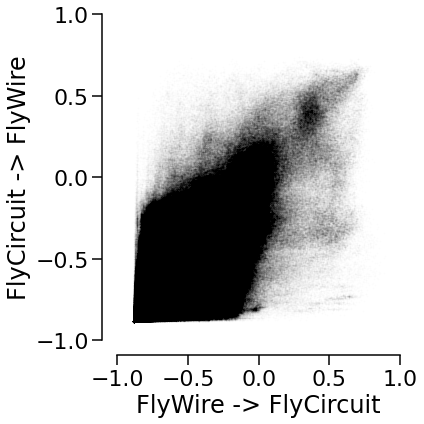

In [17]:
paired_data = np.concatenate([nbl_flywire_flycircuit.values[..., None], 
                              nbl_flycircuit_flywire.values[..., None]], axis=-1).reshape(-1, 2)

plotting.scatter_plot(*paired_data.T,
                      marker_size=2, alpha=.01,
                      xrange=[-1, 1], yrange=[-1, 1],
                      xlabel="FlyWire -> FlyCircuit",
                      ylabel="FlyCircuit -> FlyWire",
                      path=f"{figure_dir}/forwards_vs_backwards_scores.png")

In [18]:
pd.DataFrame(paired_data, columns=["fw->fc", "fc->fw"]).to_csv(f"{figure_source_dir}/a_source.csv")

## b - backwards vs forwards scores for best matches 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


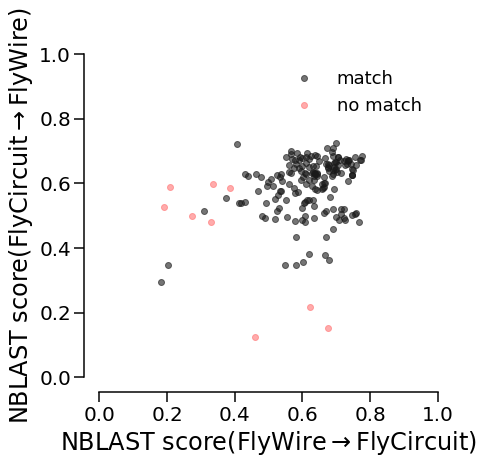

In [19]:
best_forward_backwards_scores = np.array([lineage_nbl_fwfc_packs[:, 3][rank_mean_matches[:, 3] == 0],
                                          lineage_nbl_fcfw_packs[:, 3][rank_mean_matches[:, 3] == 0]]).T

plotting.comp_scatter_plot({"match": best_forward_backwards_scores[lineage_fw_matches_fc_filter],
                            "no match": best_forward_backwards_scores[~lineage_fw_matches_fc_filter]}, 
                           color_list=[".1", "#FF7373"],
                           marker_size=6, alpha=.6,
                           figsize=[6.5, 6],
                           xrange=[0, 1], yrange=[0, 1],
                           xlabel=r"NBLAST score(FlyWire$\rightarrow$FlyCircuit)",
                           ylabel=r"NBLAST score(FlyCircuit$\rightarrow$FlyWire)",
                           path=f"{figure_dir}/nblast_best_mean_matches_forward_vs_backwards_score.png")

In [20]:
best_scores_df = pd.DataFrame(best_forward_backwards_scores, columns=["fw->fc", "fc->fw"])
best_scores_df["match"] = lineage_fw_matches_fc_filter

In [21]:
best_scores_df.to_csv(f"{figure_source_dir}/b_source.csv")

## c - Auto vs proofread scores

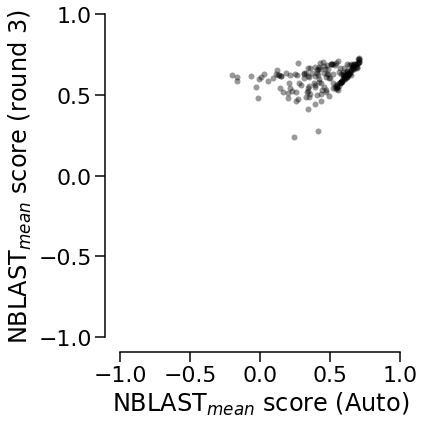

In [22]:
best_matches_before_after_mean_scores = np.array([lineage_nbl_mean_packs[:, 0][rank_mean_matches[:, 3] == 0][lineage_fw_matches_fc_filter],
                                                  lineage_nbl_mean_packs[:, 3][rank_mean_matches[:, 3] == 0][lineage_fw_matches_fc_filter]]).T

plotting.scatter_plot(*best_matches_before_after_mean_scores.T,
                      marker_size=6, alpha=.4,
                      xlabel=r"NBLAST$_{mean}$ score (Auto)", 
                      ylabel=r"NBLAST$_{mean}$ score (round 3)",
                      xrange=[-1, 1], yrange=[-1, 1],
                      path=f"{figure_dir}/nblast_score_round3_vs_auto.png")

In [23]:
pd.DataFrame(best_matches_before_after_mean_scores, columns=["auto", "proofread"]).to_csv(f"{figure_source_dir}/c_source.csv")

## d - nblast score changes through proofreading

In [24]:
best_matches_mean_score_delta = best_matches_before_after_mean_scores[:, 1] - best_matches_before_after_mean_scores[:, 0]

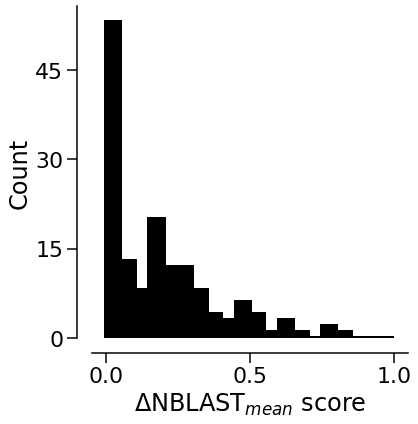

In [25]:
plotting.hist_plot(best_matches_mean_score_delta,
                   xlabel=r"$\Delta$NBLAST$_{mean}$ score", 
                   data_range=[0, 1], nbins=20, normalize=False,
                   path=f"{figure_dir}/nblast_score_round3_vs_auto_hist.png")

In [26]:
pd.DataFrame(best_matches_mean_score_delta, columns=["score_delta"]).to_csv(f"{figure_source_dir}/d_source.csv")

## e - Matched ranks

In [27]:
rank_rounds = [rank_mean_matches[:, i][rank_mean_matches[:, 3] == 0][lineage_fw_matches_fc_filter] for i in range(4)]

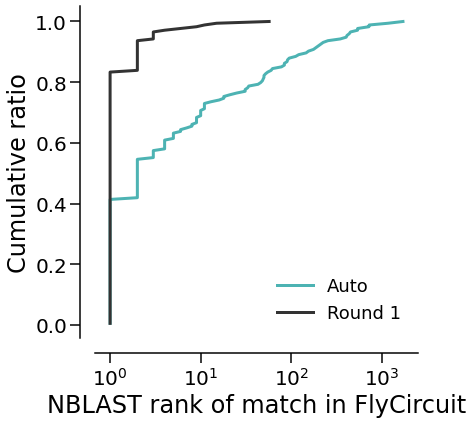

In [28]:
matches_fc_rank_rounds = np.array([rank_mean_matches[:, i][rank_mean_matches[:, 3] == 0][lineage_fw_matches_fc_filter] for i in range(4)]) + 1
matches_fc_rank_round_dict = {
    "Round 1": matches_fc_rank_rounds[1],
    "Auto": matches_fc_rank_rounds[0]
}

plotting.comp_cumplot(matches_fc_rank_round_dict, xlog=True,
                      xlabel="NBLAST rank of match in FlyCircuit", 
                      color_list=[[.3, .7, .7], [0.2, 0.2, 0.2], ],
                      path=f"{figure_dir}/nblast_rank_round1_auto.png")

In [29]:
pd.DataFrame(matches_fc_rank_round_dict).to_csv(f"{figure_source_dir}/e_source.csv")

## f - nblast auto scores - match sv no match

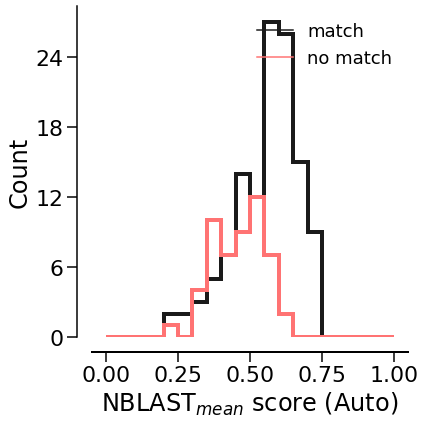

In [30]:
before_after_fc_match_mean_score_dict = {
    "match": lineage_nbl_mean_packs[:, 0][rank_mean_matches[:, 0] == 0][np.logical_and(lineage_fw_matches_fc_filter, lineage_fc_matches_fc_filter)],
    "no match": lineage_nbl_mean_packs[:, 0][rank_mean_matches[:, 0] == 0][np.logical_and(lineage_fw_matches_fc_filter, ~lineage_fc_matches_fc_filter)]
}

plotting.comp_hist_plot(before_after_fc_match_mean_score_dict,
                        color_list=[".1", "#FF7373"],
                        nbins=20,
                        normalize=False, 
                        data_range=[0, 1], 
                        show_legend=True,
                        xlabel=r"NBLAST$_{mean}$ score (Auto)",
                        path=f"{figure_dir}/nblast_score_auto_vs_match.png")

In [31]:
pd.DataFrame.from_dict(before_after_fc_match_mean_score_dict, orient="index").T.to_csv(f"{figure_source_dir}/f_source.csv")